### Importing required packages

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
import math

### Helper functions

In [2]:
def grayscale(img):
     """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    

def gaussian_blur(img, kernel_size):
           """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)


def canny(img, low_threshold, high_threshold):
        """Applies the Canny transform"""    
    return cv2.Canny(img, low_threshold, high_threshold)


def region_of_interest(img, vertices):
     """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    mask = np.zeros_like(img)   
    
    ignore_mask_color = 255
        
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be a binary image. Here it is the output of canny transform.
       
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)
    return lines


def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the extrapolate_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
 
    return cv2.addWeighted(initial_img, α, img, β, λ)


### Fuction added for extrapolation of lines obtained by Hough transform

In [37]:
def extrapolate_lines(lines,original_image):
    """
    'lines' is the output of hough transform function.
    'Original image' is the image before any processing.
    The ouput image is an all black image with only the extrapolated 
    lane markings drawn in red.
    """
    pos_slope_lines = []  
    neg_slope_lines = []
    # Separate positive and negative slope lines.
    for line in lines:
        for x1,y1,x2,y2 in line:                     
            if (y2-y1)/(x1-x2) > 0:
                pos_slope_lines.append([x1,y1,x2,y2])
            else:
                neg_slope_lines.append([x1,y1,x2,y2])

    # Find parameters of the lines and store them in list as [slope, intercept]
    pos_line_par = []
    neg_line_par = []
    
    for i in range(len(pos_slope_lines)):
            x1 = pos_slope_lines[i][0]
            y1 = pos_slope_lines[i][1]
            x2 = pos_slope_lines[i][2]
            y2 = pos_slope_lines[i][3]
            slope = (y2-y1)/(x1-x2)
            intercept = -1*y1 - slope*x1
            pos_line_par.append([slope,intercept])

    for i in range(len(neg_slope_lines)):
            x1 = neg_slope_lines[i][0]
            y1 = neg_slope_lines[i][1]
            x2 = neg_slope_lines[i][2]
            y2 = neg_slope_lines[i][3]
            slope = (y2-y1)/(x1-x2)
            intercept = -1*y1 - slope*x1
            neg_line_par.append([slope,intercept])

    # Separate slopes and intercepts from the parameter list
    pos_slopes = [pos_line_par[i][0] for i in range(len(pos_line_par)) ]
    pos_intercepts = [pos_line_par[i][1] for i in range(len(pos_line_par)) ]
    neg_slopes = [neg_line_par[i][0] for i in range(len(neg_line_par)) ]
    neg_intercepts = [neg_line_par[i][1] for i in range(len(neg_line_par)) ]

    # Calculate means of slopes and intercepts of both set of lines
    mean_pos_slope = np.mean(pos_slopes)
    mean_pos_intercept = np.mean(pos_intercepts)
    mean_neg_slope = np.mean(neg_slopes)
    mean_neg_intercept = np.mean(neg_intercepts)

    # Calculate the itersection point of positive and negative slope lines
    intercestion_point_x = int((mean_neg_intercept - mean_pos_intercept)/(mean_pos_slope - mean_neg_slope))
    intercestion_point_y = int(-mean_pos_slope*intercestion_point_x - mean_pos_intercept)

    
    line_image = np.zeros_like(original_image) # Get a blank image to draw lines on
    imshape = line_image.shape
    pos_x1 = int((- mean_pos_intercept-imshape[0])/mean_pos_slope) # Starting abcissa of positive slope line
    neg_x1 = int((- mean_neg_intercept-imshape[0])/mean_neg_slope) # Starting abcissa of negative slope line

    

    extrapolated_lines_image = cv2.line(line_image,(pos_x1,imshape[0]),(intercestion_point_x,intercestion_point_y),[255,0,0],10)
    extrapolated_lines_image = cv2.line(extrapolated_lines_image,(neg_x1,imshape[0]),(intercestion_point_x,intercestion_point_y),[255,0,0],10)
    
    # Image obtained above shows the intersection of two lane markings.
    # but we only want to see the lane markings in our region of interest. So we apply masking function once again.
    vertices = np.array([[(150,550), (400,350), (600,350), (950,550)]], dtype=np.int32)
    extrapolated_masked_image = region_of_interest(extrapolated_lines_image, vertices)
    return extrapolated_masked_image


### Updated draw_line() function

In [33]:
def draw_lines(image):
    
    gray_image = grayscale(image)
    
    kernel_size = 5
    blurrFree_image = gaussian_blur(gray_image,kernel_size)

    low_threshold = 50
    high_threshold = 150
    canny_image = canny(blurrFree_image,low_threshold,high_threshold)
    plt.subplot(2,2,1)
    plt.imshow(canny_image, cmap='gray')
    
    vertices = np.array([[(150,550), (400,350), (600,350), (950,550)]], dtype=np.int32)
    masked_image = region_of_interest(canny_image, vertices)
    plt.subplot(2,2,2)
    plt.imshow(masked_image, cmap='gray')

    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 40
    max_line_gap = 100
    lines = hough_lines(masked_image,rho,theta,threshold,min_line_len,max_line_gap)

    extended_lines_image = extrapolate_lines(lines,image)
    plt.subplot(2,2,3)
    plt.imshow(extended_lines_image)
    
    final_image = weighted_img(extended_lines_image,image)
    return final_image
    plt.subplot(2,2,4)
    plt.imshow(final_image)
    #plt.show()

### Testing the pipeline on test images

In [18]:
def fetch_image(image_path):
    return mpimg.imread(image_path)

In [16]:
test_images = [fetch_image('test_images/' + i) for i in os.listdir('test_images/')]

176 540 886


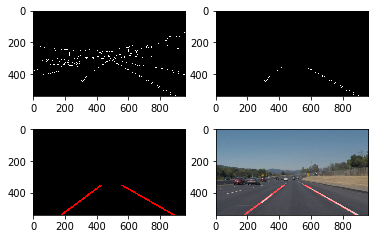

In [23]:
draw_lines(test_images[0])

152 540 845


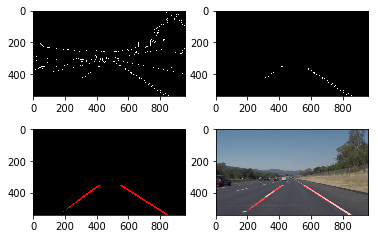

In [25]:
draw_lines(test_images[1])

169 540 862


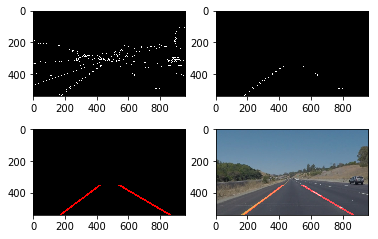

In [26]:
draw_lines(test_images[2])

155 540 868


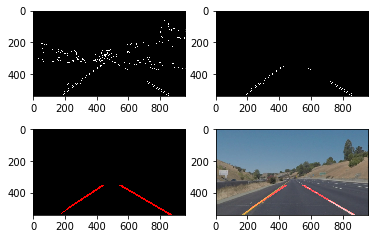

In [27]:
draw_lines(test_images[3])

165 540 851


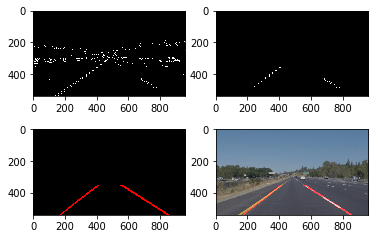

In [28]:
draw_lines(test_images[4])

171 540 876


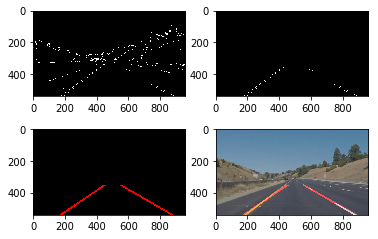

In [29]:
draw_lines(test_images[5])

### After obtaining satisfactory output on test images we apply the same pipeline on test video, frame by frame

In [30]:
from moviepy.editor import VideoFileClip

In [31]:
def process_image(image):
    """Puts image through pipeline and returns 3-channel image for processing video below."""
    result = draw_lines(image)
    return result

In [34]:
from moviepy.editor import VideoFileClip
Output_vid1 = 'Op_vid1.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
V_clip = clip1.fl_image(process_image)
V_clip.write_videofile(Output_vid1, audio=False)

158 540 858
[MoviePy] >>>> Building video Op_vid1.mp4
[MoviePy] Writing video Op_vid1.mp4


  1%|          | 2/222 [00:00<00:11, 19.73it/s]

158 540 858
165 540 854
160 540 857


  2%|▏         | 4/222 [00:00<00:11, 18.42it/s]

170 540 864


  3%|▎         | 6/222 [00:00<00:11, 18.06it/s]

161 540 867
154 540 859
159 540 860


  4%|▎         | 8/222 [00:00<00:13, 15.73it/s]

146 540 858
150 540 861
157 540 859
167 540 843


  5%|▍         | 11/222 [00:00<00:12, 16.87it/s]

164

  7%|▋         | 15/222 [00:00<00:11, 18.08it/s]

 540 832
155 540 851
159 540 834
146 540 847


  8%|▊         | 17/222 [00:00<00:11, 18.32it/s]

152 540 854
146 540 843
140 540 849
148 540 842
146 540 844


 11%|█         | 24/222 [00:01<00:10, 18.93it/s]

155 540 841
143 540 847
147 540 853
147 540 846


 13%|█▎        | 28/222 [00:01<00:10, 18.58it/s]

153 540 860
153 540 834
151 540 842
158 540 844


 14%|█▍        | 32/222 [00:01<00:10, 17.83it/s]

149 540 846
161 540 847
158 540 870
152 540 850


 16%|█▌        | 35/222 [00:01<00:10, 18.56it/s]

156 540 851
142 540 851
162 540 848
152 540 847
161 540 845

 18%|█▊        | 39/222 [00:02<00:09, 18.85it/s]


150 540 857
166 540 843
158 540 841


 19%|█▉        | 43/222 [00:02<00:10, 17.09it/s]

156 540 838
165 540 845
153 540 832
162 540 843


 21%|██        | 47/222 [00:02<00:10, 17.35it/s]

159 540 822
165 540 843
161 540 840
162 540 848


 23%|██▎       | 51/222 [00:02<00:10, 16.61it/s]

151 540 850
166 540 849
152 540 840
157 540 845


 25%|██▍       | 55/222 [00:03<00:09, 16.85it/s]

158 540 852
149 540 841
147 540 838
140 540 849


 27%|██▋       | 59/222 [00:03<00:09, 16.64it/s]

140 540 839
143 540 851
152 540 846
150 540 838


 28%|██▊       | 63/222 [00:03<00:09, 16.82it/s]

139 540 839
143 540 850
134 540 835
136 540 837


 30%|███       | 67/222 [00:03<00:09, 15.52it/s]

117 540 836
117 540 836
135 540 835


 31%|███       | 69/222 [00:04<00:10, 14.65it/s]

132 540 855
137 540 847
137 540 822
144 540 833


 33%|███▎      | 73/222 [00:04<00:10, 14.00it/s]

143 540 827
135 540 834
122 540 837


 35%|███▍      | 77/222 [00:04<00:09, 15.40it/s]

134 540 835
141 540 832
147 540 830
158 540 818


 36%|███▋      | 81/222 [00:04<00:08, 15.77it/s]

133 540 822
135 540 826
151 540 828
137 540 832


 37%|███▋      | 83/222 [00:04<00:08, 15.98it/s]

128 540 823
123 540 833
118 540 832


 39%|███▉      | 87/222 [00:05<00:10, 13.38it/s]

142 540 837
132 540 830
118 540 832


 41%|████      | 91/222 [00:05<00:09, 14.18it/s]

134 540 803
131 540 826
122 540 820
119 540 821


 43%|████▎     | 95/222 [00:05<00:08, 14.41it/s]

139 540 835
133 540 817
126 540 829


 44%|████▎     | 97/222 [00:05<00:08, 14.49it/s]

123 540 826
116 540 840
121 540 818
101 540 823


 45%|████▌     | 101/222 [00:06<00:07, 15.46it/s]

133 540 826
125 540 830
138 540 818
126 540 822


 47%|████▋     | 105/222 [00:06<00:07, 15.31it/s]

138 540 831
145 540 826
153 540 819
146 540 827


 49%|████▉     | 109/222 [00:06<00:07, 15.87it/s]

152 540 829
148 540 831
145 540 824
147 540 838


 51%|█████     | 113/222 [00:06<00:07, 15.56it/s]

155 540 831
147 540 833
144 540 836
136 540 843


 53%|█████▎    | 117/222 [00:07<00:06, 16.05it/s]

129 540 853
120 540 850
130 540 837
130 540 835


 55%|█████▍    | 121/222 [00:07<00:06, 16.01it/s]

135 540 840
131 540 845
133 540 859
149 540 853


 56%|█████▋    | 125/222 [00:07<00:06, 15.93it/s]

134 540 851
157 540 848
152 540 836
133 540 848


 58%|█████▊    | 129/222 [00:07<00:05, 15.78it/s]

145 540 857
148 540 854
155 540 853
157 540 858


 60%|█████▉    | 133/222 [00:08<00:05, 16.05it/s]

159 540 849
151 540 855
151 540 862
160 540 850


 62%|██████▏   | 137/222 [00:08<00:05, 15.87it/s]

152 540 850
154 540 859
159 540 862
151 540 854


 64%|██████▍   | 143/222 [00:08<00:04, 17.22it/s]

158 540 861
152 540 855
154 540 847
161 540 848


 66%|██████▌   | 147/222 [00:08<00:04, 17.79it/s]

159 540 848
161 540 864
164 540 853
166 540 860


 67%|██████▋   | 149/222 [00:09<00:04, 16.82it/s]

163 540 859
164 540 852
172 540 879
152 540 855


 69%|██████▉   | 153/222 [00:09<00:04, 16.48it/s]

142 540 857
165 540 859
163 540 858
170 540 859


 71%|███████   | 157/222 [00:09<00:04, 15.24it/s]

157 540 860
163 540 871
167 540 873
169 540 865


 73%|███████▎  | 161/222 [00:09<00:03, 16.41it/s]

169 540 868
162 540 875
178 540 879
169 540 884


 74%|███████▍  | 165/222 [00:10<00:03, 16.13it/s]

185 540 877
174 540 877
170 540 877
176 540 877


 76%|███████▌  | 169/222 [00:10<00:03, 15.76it/s]

190 540 873
183 540 877
176 540 880
178 540 877


 78%|███████▊  | 173/222 [00:10<00:03, 15.55it/s]

180 540 875
178 540 876
187 540 882
186 540 872


 80%|███████▉  | 177/222 [00:10<00:03, 14.95it/s]

189 540 881
184 540 877
186 540 885
194 540 876


 82%|████████▏ | 181/222 [00:11<00:02, 15.52it/s]

195 540 886
187 540 900
186 540 892
183 540 881


 84%|████████▍ | 187/222 [00:11<00:02, 16.91it/s]

185 540 866
188 540 866
180 540 884
187 540 885


 86%|████████▌ | 191/222 [00:11<00:01, 17.38it/s]

185 540 881
186 540 891
176 540 890
177 540 879


 87%|████████▋ | 193/222 [00:11<00:01, 17.53it/s]

184 540 903
191 540 886
190 540 896
179 540 884


 90%|████████▉ | 199/222 [00:12<00:01, 17.46it/s]

194 540 887
185 540 879
185 540 875
186 540 892


 91%|█████████ | 201/222 [00:12<00:01, 17.65it/s]

175 540 871
176 540 887
179 540 886
190 540 890


 92%|█████████▏| 205/222 [00:12<00:01, 16.99it/s]

198 540 894
174 540 893
185 540 883
180 540 904


 95%|█████████▌| 211/222 [00:12<00:00, 16.63it/s]

183 540 907
188 540 899
193 540 898
188 540 893


 97%|█████████▋| 215/222 [00:13<00:00, 16.91it/s]

189 540 896
184 540 884
180 540 887
184 540 889


 99%|█████████▊| 219/222 [00:13<00:00, 17.71it/s]

179 540 891
191 540 888
191 540 894
191 540 884


100%|█████████▉| 221/222 [00:13<00:00, 17.57it/s]


183 540 890
179 540 887
[MoviePy] Done.
[MoviePy] >>>> Video ready: Op_vid1.mp4 



In [35]:
Output_vid2 = 'Op_vid2.mp4'
clip1 = VideoFileClip("test_videos/solidYellowLeft.mp4")
V_clip = clip1.fl_image(process_image)
V_clip.write_videofile(Output_vid2, audio=False)

109 540 836
[MoviePy] >>>> Building video Op_vid2.mp4
[MoviePy] Writing video Op_vid2.mp4


  0%|          | 2/682 [00:00<00:36, 18.46it/s]

109 540 836
99 540 833
110 540 826


  1%|          | 4/682 [00:00<00:36, 18.43it/s]

126 540 835


  1%|          | 6/682 [00:00<00:36, 18.64it/s]

161 540 829
146 540 838
124 540 840


  1%|          | 8/682 [00:00<00:36, 18.64it/s]

145 540 835


  1%|▏         | 10/682 [00:00<00:37, 18.05it/s]

131 540 840
140 540 839
132 540 840


  2%|▏         | 12/682 [00:00<00:38, 17.40it/s]

138 540 852


  2%|▏         | 14/682 [00:00<00:38, 17.56it/s]

139 540 849
148 540 841
155 540 844


  2%|▏         | 16/682 [00:00<00:38, 17.18it/s]

144 540 854


  3%|▎         | 18/682 [00:01<00:37, 17.85it/s]

145 540 858
143 540 861
140 540 850


  3%|▎         | 20/682 [00:01<00:38, 17.38it/s]

151 540 851
141 540 856
140 540 856


  3%|▎         | 22/682 [00:01<00:38, 17.06it/s]

146 540 860
147 540 856


  4%|▎         | 24/682 [00:01<00:39, 16.69it/s]

150 540 855
153 540 852


  4%|▍         | 26/682 [00:01<00:39, 16.49it/s]

172 540 861
163 540 864


  4%|▍         | 30/682 [00:01<00:37, 17.54it/s]

165 540 876
145 540 871
169 540 873


  5%|▍         | 32/682 [00:01<00:36, 17.81it/s]

155 540 866
151 540 857
166 540 877


  5%|▌         | 35/682 [00:01<00:35, 18.11it/s]

168 540 865
167 540 859


  5%|▌         | 37/682 [00:02<00:35, 18.02it/s]

150 540 869
166 540 878


  6%|▌         | 39/682 [00:02<00:35, 18.25it/s]

164 540 873
168 540 863


  6%|▌         | 41/682 [00:02<00:38, 16.67it/s]

155 540 883
159 540 873


  6%|▋         | 43/682 [00:02<00:42, 15.13it/s]

150 540 879
158 540 881


  7%|▋         | 45/682 [00:02<00:41, 15.51it/s]

160 540 880
162 540 860


  7%|▋         | 47/682 [00:02<00:39, 16.09it/s]

155 540 873
172 540 866


  7%|▋         | 49/682 [00:02<00:39, 15.88it/s]

169 540 862
148 540 867


  7%|▋         | 51/682 [00:03<00:40, 15.66it/s]

148 540 859
163

  8%|▊         | 53/682 [00:03<00:40, 15.65it/s]

 540 862
154 540 870
157 540 873
158 540 867


  8%|▊         | 57/682 [00:03<00:38, 16.15it/s]

144 540 869
149 540 867
156 540 858
147 540 880


  9%|▉         | 61/682 [00:03<00:38, 16.15it/s]

160 540 870
153 540 859
148 540 862
146 540 868

  9%|▉         | 63/682 [00:03<00:40, 15.32it/s]


145 540 866
155 540 882


 10%|▉         | 67/682 [00:04<00:44, 13.81it/s]

145 540 864
150 540 864
140 540 863


 10%|█         | 69/682 [00:04<00:45, 13.38it/s]

152 540 846
157 540 858
154

 10%|█         | 71/682 [00:04<00:44, 13.64it/s]

 540 847


 11%|█         | 73/682 [00:04<00:43, 14.07it/s]

169 540 850
147 540 856
150 540 849
155 540 853


 11%|█▏        | 77/682 [00:04<00:41, 14.48it/s]

166 540 850
155 540 848
183 540 860


 12%|█▏        | 79/682 [00:04<00:43, 13.74it/s]

149 540 843
164 540 844


 12%|█▏        | 81/682 [00:05<00:43, 13.82it/s]

166 540 837


 12%|█▏        | 83/682 [00:05<00:44, 13.31it/s]

149 540 862
143 540 851
149 540 857
149 540 842


 12%|█▏        | 85/682 [00:05<00:43, 13.88it/s]

150 540 855
153 540 855


 13%|█▎        | 87/682 [00:05<00:41, 14.50it/s]

149 540 848
138 540 848


 13%|█▎        | 89/682 [00:05<00:38, 15.38it/s]

142 540 853
155 540 849

 13%|█▎        | 91/682 [00:05<00:39, 14.83it/s]


143 540 847


 14%|█▎        | 93/682 [00:05<00:42, 14.00it/s]

147 540 838


 14%|█▍        | 95/682 [00:06<00:41, 14.15it/s]

137 540 832
145 540 834
155 540 833
143 540 845


 14%|█▍        | 97/682 [00:06<00:41, 14.02it/s]

153 540 840


 15%|█▍        | 99/682 [00:06<00:42, 13.74it/s]

185 540 837
161 540 860


 15%|█▍        | 101/682 [00:06<00:40, 14.46it/s]

154 540 862
176 540 851


 15%|█▌        | 103/682 [00:06<00:38, 14.96it/s]

143 540 843
153 540 843


 15%|█▌        | 105/682 [00:06<00:38, 15.13it/s]

133 540 854
152 540 849


 16%|█▌        | 107/682 [00:06<00:36, 15.92it/s]

142 540 853
158 540 857


 16%|█▌        | 109/682 [00:06<00:35, 16.27it/s]

147 540 851
128 540 838


 16%|█▋        | 111/682 [00:07<00:36, 15.52it/s]

144 540 846


 17%|█▋        | 113/682 [00:07<00:38, 14.94it/s]

154 540 851
157 540 847
159 540 844


 17%|█▋        | 115/682 [00:07<00:43, 13.05it/s]

167 540 848
134 540 848
162 540 840


 17%|█▋        | 119/682 [00:07<00:41, 13.56it/s]

152 540 855
151 540 847
151 540 853
152 540 848


 18%|█▊        | 123/682 [00:07<00:36, 15.23it/s]

134 540 847
141 540 851
150 540 845
153 540 847


 18%|█▊        | 125/682 [00:08<00:36, 15.28it/s]

144 540 852
156 540 852


 19%|█▉        | 129/682 [00:08<00:33, 16.42it/s]

170 540 843
155 540 851
163 540 852
155 540 856


 19%|█▉        | 131/682 [00:08<00:33, 16.39it/s]

163 540 843
167 540 850


 20%|█▉        | 133/682 [00:08<00:33, 16.37it/s]

154 540 853
153 540 844


 20%|█▉        | 135/682 [00:08<00:36, 15.01it/s]

156 540 834


 20%|██        | 137/682 [00:08<00:36, 14.90it/s]

146 540 871
154 540 844
159

 20%|██        | 139/682 [00:09<00:36, 15.01it/s]

 540 856
176 540 853


 21%|██        | 141/682 [00:09<00:36, 14.87it/s]

159 540 849


 21%|██        | 143/682 [00:09<00:37, 14.44it/s]

152 540 843
164 540 847
176 540 848


 21%|██▏       | 145/682 [00:09<00:37, 14.43it/s]

155 540 846
157 540 847


 22%|██▏       | 147/682 [00:09<00:36, 14.54it/s]

160 540 844
146 540 853


 22%|██▏       | 149/682 [00:09<00:37, 14.21it/s]

150 540 852


 22%|██▏       | 151/682 [00:09<00:37, 14.26it/s]

162 540 845
166 540 873
170 540 866
162 540 851


 22%|██▏       | 153/682 [00:09<00:35, 14.95it/s]

153 540 863


 23%|██▎       | 155/682 [00:10<00:36, 14.36it/s]

140 540 857
155 540 859


 23%|██▎       | 157/682 [00:10<00:38, 13.75it/s]

156 540 871


 23%|██▎       | 159/682 [00:10<00:38, 13.66it/s]

168 540 855
158 540 861
158 540 856


 24%|██▎       | 161/682 [00:10<00:37, 13.78it/s]

155 540 863
177 540 862
157 540 860


 24%|██▍       | 165/682 [00:10<00:37, 13.72it/s]

174 540 860
155 540 873
181 540 880


 25%|██▍       | 169/682 [00:11<00:34, 14.90it/s]

164 540 865
162 540 883
165 540 878
168 540 870


 25%|██▌       | 173/682 [00:11<00:31, 15.96it/s]

164 540 882
173 540 884
185 540 885
166 540 884


 26%|██▌       | 177/682 [00:11<00:30, 16.79it/s]

179 540 885
174 540 889
184 540 878
178 540 888


 27%|██▋       | 181/682 [00:11<00:28, 17.34it/s]

181 540 876
178 540 883
179 540 905
182 540 902


 27%|██▋       | 185/682 [00:12<00:29, 16.87it/s]

174 540 883
177 540 899
183 540 895
181 540 884


 28%|██▊       | 189/682 [00:12<00:30, 16.16it/s]

185 540 886
185 540 893
199 540 893
194 540 889


 28%|██▊       | 193/682 [00:12<00:32, 15.11it/s]

184 540 891
190 540 879
174 540 900


 29%|██▊       | 195/682 [00:12<00:31, 15.27it/s]

180 540 903
185 540 891
182 540 875
182 540 891


 29%|██▉       | 201/682 [00:13<00:28, 16.91it/s]

190 540 883
188 540 873
188 540 881
172 540 893


 30%|███       | 205/682 [00:13<00:27, 17.31it/s]

186 540 880
200 540 889
183 540 885
175 540 880


 30%|███       | 207/682 [00:13<00:27, 17.29it/s]

165 540 875
172 540 874
183 540 877
183 540 884


 31%|███       | 213/682 [00:13<00:26, 17.50it/s]

173 540 866
168 540 856
172 540 864
165 540 859


 32%|███▏      | 215/682 [00:13<00:26, 17.31it/s]

156 540 873
162 540 866
168 540 850
161 540 870


 32%|███▏      | 220/682 [00:14<00:26, 17.58it/s]

162 540 861
168 540 862
154 540 855
162 540 864


 33%|███▎      | 224/682 [00:14<00:25, 17.79it/s]

168 540 859
160 540 858
160 540 860
160 540 861


 33%|███▎      | 228/682 [00:14<00:26, 17.06it/s]

173 540 863
162 540 853
169 540 863
156 540 860


 34%|███▍      | 232/682 [00:14<00:26, 17.24it/s]

161 540 866
170 540 861
155 540 849
154 540 842


 35%|███▍      | 236/682 [00:15<00:26, 17.02it/s]

153 540 850
154 540 855
154 540 858
156 540 863


 35%|███▌      | 240/682 [00:15<00:25, 17.22it/s]

160 540 856
151 540 861
154 540 864
153 540 866


 36%|███▌      | 244/682 [00:15<00:25, 17.47it/s]

155 540 872
165 540 872
148 540 879
141 540 867


 36%|███▋      | 248/682 [00:15<00:25, 17.04it/s]

153 540 861
164 540 865
164 540 854
156 540 874


 37%|███▋      | 252/682 [00:15<00:24, 17.72it/s]

155 540 870
152 540 865
158 540 865
175 540 851


 38%|███▊      | 256/682 [00:16<00:24, 17.10it/s]

164 540 856
157 540 856
175 540 864
171 540 860


 38%|███▊      | 260/682 [00:16<00:24, 16.97it/s]

166 540 849
163 540 855
159 540 859
184 540 850


 39%|███▊      | 264/682 [00:16<00:23, 17.45it/s]

161 540 850
161 540 853
159 540 860
157 540 863


 39%|███▉      | 268/682 [00:16<00:23, 17.61it/s]

160 540 860
158 540 855
154 540 867
158 540 859


 40%|███▉      | 272/682 [00:17<00:24, 16.73it/s]

158 540 861
159 540 881
148 540 858
167 540 866


 40%|████      | 276/682 [00:17<00:23, 17.43it/s]

161 540 870
164 540 875
162 540 887
136 540 876


 41%|████      | 280/682 [00:17<00:22, 17.65it/s]

149 540 875
160 540 864
162 540 870
152 540 873


 42%|████▏     | 284/682 [00:17<00:23, 16.72it/s]

164 540 904
168 540 927
151 540 876
161 540 892


 42%|████▏     | 288/682 [00:18<00:22, 17.16it/s]

173 540 945
177 540 923
162 540 908
148 540 886


 43%|████▎     | 292/682 [00:18<00:23, 16.66it/s]

189 540 861
183 540 862
171 540 868
164 540 850


 43%|████▎     | 296/682 [00:18<00:22, 16.93it/s]

163 540 858
182 540 870
167 540 859
162 540 865


 44%|████▍     | 300/682 [00:18<00:21, 17.37it/s]

152 540 858
174 540 857
169 540 856
168 540 850


 45%|████▍     | 304/682 [00:19<00:21, 17.37it/s]

163 540 837
171 540 841
157 540 848
165 540 849


 45%|████▌     | 308/682 [00:19<00:23, 16.20it/s]

166 540 847
163 540 860
162 540 862
162 540 852


 46%|████▌     | 313/682 [00:19<00:21, 17.38it/s]

156 540 862
157 540 855
165 540 868
163 540 854


 46%|████▌     | 315/682 [00:19<00:21, 16.92it/s]

169 540 859
166 540 857
156 540 860
164 540 859


 47%|████▋     | 319/682 [00:19<00:20, 17.48it/s]

173 540 859
153 540 869
156 540 864
176 540 869


 47%|████▋     | 323/682 [00:20<00:21, 17.08it/s]

162 540 858
161 540 853
163 540 875
152 540 859


 48%|████▊     | 327/682 [00:20<00:20, 17.01it/s]

153 540 860
154 540 861
169 540 857
143 540 863


 49%|████▉     | 333/682 [00:20<00:20, 17.25it/s]

157 540 857
153 540 860
140 540 866
150 540 854


 49%|████▉     | 337/682 [00:20<00:19, 17.43it/s]

159 540 847
149 540 853
148 540 846
146 540 855


 50%|████▉     | 339/682 [00:21<00:21, 16.07it/s]

144 540 856
153 540 849
156 540 842
149

 50%|█████     | 341/682 [00:21<00:21, 16.01it/s]

 540 849
140 540 850
156 540 854


 51%|█████     | 347/682 [00:21<00:23, 14.27it/s]

145 540 850
145 540 846
148 540 847
161 540 855


 51%|█████▏    | 351/682 [00:21<00:20, 15.86it/s]

162 540 842
149 540 852
144 540 847
150 540 849


 52%|█████▏    | 355/682 [00:22<00:18, 17.22it/s]

153 540 850
168 540 861
148 540 852
151 540 854


 53%|█████▎    | 359/682 [00:22<00:18, 17.51it/s]

149 540 871
167 540 857
157 540 855
160 540 853


 53%|█████▎    | 361/682 [00:22<00:19, 16.50it/s]

147 540 856
162 540 851
158 540 862
159 540 877


 54%|█████▍    | 367/682 [00:22<00:18, 16.99it/s]

169 540 888
150 540 894
160 540 848
126 540 860


 54%|█████▍    | 371/682 [00:23<00:17, 17.59it/s]

151 540 977
144 540 951
156 540 899
161 540 909


 55%|█████▍    | 373/682 [00:23<00:17, 17.44it/s]

232 540 861
162 540 853
144 540 860
165 540 846


 55%|█████▌    | 377/682 [00:23<00:20, 15.10it/s]

145 540 843
154 540 854
151 540 853


 56%|█████▌    | 381/682 [00:23<00:19, 15.28it/s]

151 540 857
153 540 854
170 540 869
162 540 846


 56%|█████▋    | 385/682 [00:23<00:19, 15.03it/s]

150 540 851
147 540 848
154 540 852


 57%|█████▋    | 387/682 [00:24<00:19, 14.94it/s]

135 540 848
150 540 851
170 540 835
147 540 856


 57%|█████▋    | 392/682 [00:24<00:17, 16.97it/s]

153 540 843
142 540 853
140 540 844
130 540 851
137 540 846


 58%|█████▊    | 398/682 [00:24<00:16, 17.40it/s]

133 540 832
141 540 835
141 540 835
140 540 852


 59%|█████▉    | 402/682 [00:24<00:15, 17.53it/s]

144 540 836
142 540 837
141 540 842
147 540 836


 60%|█████▉    | 406/682 [00:25<00:15, 17.64it/s]

163 540 845
148 540 835
140 540 833
146 540 839


 60%|██████    | 410/682 [00:25<00:15, 17.69it/s]

140 540 836
148 540 843
142 540 836
146 540 844


 60%|██████    | 412/682 [00:25<00:15, 17.20it/s]

141 540 839
141 540 842
140 540 839
145 540 839


 61%|██████    | 416/682 [00:25<00:16, 16.52it/s]

156 540 849
135 540 845
142 540 850
144 540 838


 62%|██████▏   | 420/682 [00:26<00:16, 16.25it/s]

145 540 847
148 540 863
145 540 839
145 540 835


 62%|██████▏   | 424/682 [00:26<00:15, 16.14it/s]

144 540 842
140 540 845
159 540 838
151 540 838


 63%|██████▎   | 428/682 [00:26<00:16, 15.20it/s]

144 540 855
149 540 838
144 540 839


 63%|██████▎   | 432/682 [00:26<00:17, 14.54it/s]

143 540 835
140 540 839
146 540 829
162 540 845


 64%|██████▍   | 436/682 [00:27<00:16, 15.14it/s]

152 540 850
164 540 854
166 540 847
148 540 836


 65%|██████▍   | 440/682 [00:27<00:17, 13.83it/s]

140 540 847
138 540 851
146 540 848


 65%|██████▍   | 442/682 [00:27<00:17, 14.04it/s]

153 540 849
146 540 849
146 540 846


 65%|██████▌   | 446/682 [00:27<00:16, 14.50it/s]

160 540 849
150 540 842
137 540 838


 66%|██████▌   | 448/682 [00:27<00:16, 13.89it/s]

140 540 842
143 540 845
139 540 847


 66%|██████▋   | 452/682 [00:28<00:16, 13.64it/s]

132 540 846
131 540 850
138 540 840


 67%|██████▋   | 454/682 [00:28<00:15, 14.50it/s]

128 540 851
114 540 848
142 540 856
136 540 844


 67%|██████▋   | 458/682 [00:28<00:15, 14.92it/s]

144 540 848
134 540 839
119 540 869
132

 68%|██████▊   | 462/682 [00:28<00:15, 14.48it/s]

 540 872
148 540 911
134 540 875
135 540 870
130

 68%|██████▊   | 466/682 [00:29<00:15, 13.89it/s]

 540 872
143 540 848
134 540 842


 69%|██████▊   | 468/682 [00:29<00:14, 14.63it/s]

148 540 863
128 540 856
149 540 849
141 540 849


 69%|██████▉   | 472/682 [00:29<00:13, 15.31it/s]

137 540 847
161 540 847
164 540 854
155 540 840


 70%|██████▉   | 476/682 [00:29<00:14, 14.63it/s]

151 540 842
140 540 841
127 540 840


 70%|███████   | 480/682 [00:30<00:14, 14.35it/s]

142 540 843
144 540 857
149 540 838


 71%|███████   | 482/682 [00:30<00:13, 14.40it/s]

147 540 843
153 540 845
149 540 839
134 540 845


 71%|███████▏  | 486/682 [00:30<00:12, 15.48it/s]

147 540 844
148 540 851
165 540 855
137 540 841


 72%|███████▏  | 490/682 [00:30<00:13, 14.49it/s]

148 540 847
162 540 840
159 540 846


 72%|███████▏  | 494/682 [00:31<00:13, 14.16it/s]

152 540 844
157 540 840
153 540 845


 73%|███████▎  | 496/682 [00:31<00:12, 14.53it/s]

167 540 844
156 540 844
159 540 856
164 540 

 73%|███████▎  | 500/682 [00:31<00:12, 14.35it/s]

841
153 540 862
152 540 851
149 540 860


 74%|███████▍  | 504/682 [00:31<00:11, 15.13it/s]

152 540 852
145 540 853
142 540 853
143 540 864


 74%|███████▍  | 508/682 [00:32<00:11, 15.44it/s]

149 540 855
144 540 858
137 540 854


 75%|███████▍  | 510/682 [00:32<00:11, 14.46it/s]

146 540 853
155 540 845
166 540 860
145 540 845


 75%|███████▌  | 514/682 [00:32<00:11, 15.24it/s]

145 540 849
149 540 835
134 540 850
142 540 851


 76%|███████▌  | 518/682 [00:32<00:10, 15.05it/s]

144 540 842
133 540 849
136 540 848
139 540 863


 77%|███████▋  | 522/682 [00:33<00:11, 13.78it/s]

128 540 837
136 540 853
141 540 857


 77%|███████▋  | 526/682 [00:33<00:11, 14.11it/s]

159 540 844
143 540 850
146 540 847


 77%|███████▋  | 528/682 [00:33<00:11, 13.67it/s]

146 540 845
142 540 843
139 540 859


 78%|███████▊  | 532/682 [00:33<00:11, 13.08it/s]

134 540 840
145 540 846
151 540 837


 78%|███████▊  | 534/682 [00:33<00:11, 13.13it/s]

139 540 840
139 540 855
151 540 848


 79%|███████▉  | 538/682 [00:34<00:10, 13.09it/s]

154 540 845
178 540 857
182 540 844


 79%|███████▉  | 540/682 [00:34<00:11, 12.28it/s]

142 540 841
160 540 854
155 540 846


 80%|███████▉  | 544/682 [00:34<00:11, 12.54it/s]

159 540 851
153 540 854
150 540 845


 80%|████████  | 546/682 [00:34<00:11, 12.33it/s]

149 540 849
155 540 843
161 540 854


 80%|████████  | 548/682 [00:35<00:10, 12.62it/s]

154 540 853
144 540 858
162 540 859


 81%|████████  | 554/682 [00:35<00:08, 14.31it/s]

151 540 861
161 540 862
154 540 853
160 540 851


 82%|████████▏ | 556/682 [00:35<00:08, 14.97it/s]

163 540 858
157 540 855
164 540 852
167 540 862


 82%|████████▏ | 560/682 [00:35<00:08, 14.50it/s]

151 540 853
160 540 867
158 540 861


 83%|████████▎ | 564/682 [00:36<00:08, 13.78it/s]

146 540 867
174 540 869
158 540 867


 83%|████████▎ | 566/682 [00:36<00:08, 14.08it/s]

162 540 865
160 540 846
168 540 862
171 540 865


 84%|████████▍ | 572/682 [00:36<00:06, 16.10it/s]

163 540 862
164 540 866
167 540 886
170 540 884


 84%|████████▍ | 574/682 [00:36<00:06, 16.18it/s]

173 540 873
174 540 876
185 540 872
172 540 871


 85%|████████▍ | 578/682 [00:37<00:06, 15.29it/s]

173 540 872
174 540 867
171 540 861
182 540 877


 85%|████████▌ | 582/682 [00:37<00:06, 15.95it/s]

171 540 874
171 540 874
173 540 880


 86%|████████▌ | 586/682 [00:37<00:06, 15.42it/s]

192 540 877
180 540 867
166 540 887
168 540 873


 87%|████████▋ | 590/682 [00:37<00:05, 15.71it/s]

172 540 886
192 540 880
174 540 892
179 540 886


 87%|████████▋ | 594/682 [00:38<00:05, 15.67it/s]

177 540 875
180 540 881
172 540 868
182

 87%|████████▋ | 596/682 [00:38<00:05, 15.59it/s]

 540 867
177 540 867
175 540 868
190 540 867


 88%|████████▊ | 600/682 [00:38<00:05, 16.01it/s]

175 540 875
180 540 863
181 540 877
177 540 875


 89%|████████▉ | 606/682 [00:38<00:04, 16.28it/s]

173 540 894
182 540 873
178 540 876
180 540 881


 89%|████████▉ | 608/682 [00:38<00:04, 16.46it/s]

180 540 886
181 540 906
184 540 891
187 540 869


 90%|████████▉ | 612/682 [00:39<00:04, 16.80it/s]

189 540 883
181 540 893
197 540 881


 90%|█████████ | 616/682 [00:39<00:04, 15.75it/s]

206 540 883
196 540 864
192 540 889
189 540 877


 91%|█████████ | 620/682 [00:39<00:03, 16.61it/s]

191 540 885
192 540 883
199 540 888
215 540 878


 91%|█████████ | 622/682 [00:39<00:03, 16.61it/s]

197 540 888


 92%|█████████▏| 626/682 [00:40<00:04, 13.25it/s]

200 540 899
193 540 891
209 540 896
198 540 893


 92%|█████████▏| 628/682 [00:40<00:03, 13.99it/s]

198 540 897
196 540 881
201 540 888
197 540 908


 93%|█████████▎| 632/682 [00:40<00:03, 15.62it/s]

203 540 884
196 540 902
195 540 883
189 540 908


 93%|█████████▎| 636/682 [00:40<00:02, 15.71it/s]

206 540 885
202 540 894
184 540 893
191 540 887


 94%|█████████▍| 640/682 [00:41<00:02, 14.74it/s]

197 540 879
187 540 883
180 540 883
182 540 881


 95%|█████████▍| 646/682 [00:41<00:02, 16.59it/s]

182 540 885
179 540 886
179 540 908
183 540 880


 95%|█████████▌| 648/682 [00:41<00:02, 15.98it/s]

178 540 877
183 540 877
179 540 863
183 540 874


 96%|█████████▌| 652/682 [00:41<00:01, 15.26it/s]

178 540 868
182 540 863
177 540 878
183 540 856


 96%|█████████▋| 658/682 [00:42<00:01, 16.23it/s]

171 540 861
168 540 867
171 540 870
188 540 878


 97%|█████████▋| 660/682 [00:42<00:01, 16.32it/s]

180 540 861
176 540 864
167 540 865


 97%|█████████▋| 664/682 [00:42<00:01, 15.76it/s]

145 540 867
161 540 864
158 540 867
158 540 872


 98%|█████████▊| 668/682 [00:42<00:00, 15.43it/s]

165 540 869
160 540 870
163 540 862


 98%|█████████▊| 670/682 [00:42<00:00, 14.59it/s]

157 540 867
155 540 861
155 540 862


 99%|█████████▉| 674/682 [00:43<00:00, 15.38it/s]

155 540 861
153 540 862
141 540 854
154 540 870


 99%|█████████▉| 678/682 [00:43<00:00, 16.08it/s]

177 540 872
164 540 868
168 540 858
163 540 857


100%|█████████▉| 681/682 [00:43<00:00, 15.59it/s]

165 540 854
159 540 857


[MoviePy] Done.
[MoviePy] >>>> Video ready: Op_vid2.mp4 



The output video for solidWhiteRight is showing good tracking of lane markings whereas for solidYellow left, it has one or two glitches in between. We can consider this as satisfactory.

### Applying pipeline on challenge video

In [36]:
Output_vid3 = 'Op_vid3.mp4'
clip1 = VideoFileClip("test_videos/challenge.mp4")
V_clip = clip1.fl_image(process_image)
V_clip.write_videofile(Output_vid3, audio=False)

-374 720 658
[MoviePy] >>>> Building video Op_vid3.mp4
[MoviePy] Writing video Op_vid3.mp4


  0%|          | 0/251 [00:00<?, ?it/s]

-374 720 658


  1%|          | 2/251 [00:00<00:28,  8.76it/s]

-455 720 1372


  1%|          | 3/251 [00:00<00:27,  9.09it/s]

-246 720 1441


  2%|▏         | 4/251 [00:00<00:26,  9.26it/s]

-198 720 979
-222 720 1642


ValueError: cannot convert float NaN to integer

The presented pipeline doesnot work on the challenge video.